In [9]:
pip install gymnasium torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
### Step 1: Setup and Dependencies

# Install dependencies if needed (uncomment the next line)
# !pip install gym torch numpy matplotlib

import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque

#### Understanding the Deep Q-Network (DQN) Architecture
The neural network used in DQN acts as a function approximator to estimate the Q-values for given state-action pairs. This network helps the agent learn the optimal action selection policy.

##### Architecture:
1. **Input Layer**: Takes the state representation as input.
   - The input to the network is a representation of the environment's current state.
   - For example, in the **CartPole-v1** environment, the state consists of four values:
     - Cart position (continuous value, e.g., `0.02` meters)
     - Cart velocity (continuous value, e.g., `-0.05` m/s)
     - Pole angle (continuous value, e.g., `0.03` radians)
     - Pole velocity at tip (continuous value, e.g., `0.02` rad/s)
   - These values are passed as a **4-dimensional vector** into the input layer.

2. **Hidden Layers**: 
   - **First Linear Layer (fc1)**: Maps the input to a 24-dimensional space.
   - **ReLU Activation**: Introduces non-linearity to capture complex relationships.
   - **Second Linear Layer (fc2)**: Further transforms the 24-dimensional representation.
   - **ReLU Activation**: Ensures non-linearity remains.
   - **Output Layer (fc3)**: Maps the transformed feature representation to action space.

Below is the implementation:

In [11]:
### Step 2: Define the Neural Network

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)



##### Why 3 Linear and 2 ReLU Layers?
- **Feature Extraction**: The first linear layer helps extract meaningful features from raw state input.
- **Non-linearity for Better Learning**: The ReLU activation introduces non-linearity, allowing the network to learn complex patterns instead of just linear mappings.
- **Further Feature Transformation**: The second linear layer refines extracted features, and the second ReLU activation ensures further complexity in representation.
- **Output Mapping**: The final linear layer directly maps transformed features to Q-values corresponding to different actions.

##### Why are ReLU Layers Encapsulated in a `forward` Method?
- In PyTorch, the `forward` method defines how data passes through the network.
- **What Does It Mean That Data Passes Through the Network?**
  - When an input (state) is fed into the network, it undergoes a series of transformations via weighted computations and activation functions.
  - The network's layers sequentially apply transformations: first mapping the input to hidden representations, then refining those representations, and finally producing Q-values.
  - This step-by-step transformation process is what is meant by "data passing through the network."
- **Encapsulation Benefits**:
  - Separating structure (layer definitions) from execution (how data is processed) makes the code modular and easier to maintain.
  - The `forward` method ensures a clean, reusable implementation that allows easy modifications to the network's processing logic.

In [12]:
### Step 3: Initialize the Environment

env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Set up DQN
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
criterion = nn.MSELoss()

epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.99  # Discount factor

### Understanding Epsilon and Gamma in Step 3

#### **Epsilon (ε) - Exploration Rate**
- **`epsilon = 1.0`**: The agent starts with full exploration, meaning it selects random actions initially to discover different state-action pairs.
- **`epsilon_decay = 0.995`**: With each training episode, `epsilon` is multiplied by `0.995`, reducing the probability of random actions gradually.
- **`epsilon_min = 0.01`**: Ensures that exploration never completely stops. Even after many episodes, the agent will still take random actions **1% of the time** to avoid getting stuck in local optima.

#### **Why It Matters?**
- **The exploration-exploitation tradeoff**: Initially, the agent explores to gather information. Over time, it exploits what it has learned to maximize rewards.
- If `epsilon` decays too quickly, the agent might settle on a suboptimal strategy before it has fully explored the environment.
- If `epsilon_min` is too high, the agent may continue taking random actions even when it has learned a good strategy.

#### **Gamma (γ) - Discount Factor**
- **`gamma = 0.99`**: This controls how much future rewards matter compared to immediate rewards.

#### **Why a High Gamma?**
- Encourages the agent to **seek long-term rewards** rather than just maximizing short-term gains.
- In the **CartPole-v1** environment, balancing the pole for a longer duration is the goal. A lower gamma (e.g., `0.5`) would make the agent focus only on short-term survival rather than learning how to extend episodes as much as possible.
  
#### **How These Parameters Affect Learning?**
- In the training loop, `epsilon` decreases over time, shifting the agent from an **exploratory** phase (random moves) to an **exploitative** phase (choosing the best-known moves).
- The discount factor `gamma` ensures that rewards received **several steps into the future** influence current decision-making, which is crucial for solving reinforcement learning problems where delayed rewards exist.

##### How This Helps DQN Implementation
- **Approximating Q-Values**: In the **CartPole-v1** use case, the Q-value represents the expected cumulative reward for taking an action in a given state. The network predicts Q-values for all possible actions, and the agent selects the action with the highest Q-value to maximize long-term reward.
- **Efficient Convergence**: Convergence is achieved when the network stabilizes its Q-value predictions. A **gradient** (the derivative of the loss function with respect to network parameters) helps update weights through backpropagation. ReLU activation prevents **vanishing gradients**, ensuring the network learns effectively.
- **Balancing Complexity and Performance**: A deeper network may overfit, meaning it memorizes specific scenarios rather than generalizing to new ones. Too shallow a network may fail to capture essential features. The current setup balances learning capacity and computational efficiency, ensuring good performance in unseen states.

In [13]:
### Step 4: Preprocess the Input

def preprocess_state(state):
    return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

In [14]:
### Step 5: Experience Replay Buffer

replay_buffer = deque(maxlen=2000)

def add_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

def sample_experiences(batch_size=32):
    return random.sample(replay_buffer, batch_size)



### Understanding the Replay Buffer in DQN

A **Replay Buffer** (also known as Experience Replay) is a crucial component of Deep Q-Networks (DQN). It helps improve learning efficiency and stability by storing past experiences and reusing them during training.

#### What is the Replay Buffer?
- It is a memory buffer that stores **past experiences** in the form of `(state, action, reward, next_state, done)` tuples.
- Instead of learning from consecutive experiences, the agent samples random mini-batches from this buffer to **break correlation between consecutive experiences**.
- This prevents the network from overfitting to recent experiences and helps it learn generalizable policies.

#### Why is the Replay Buffer Important?
- **Stabilizes Learning**: Since updates are based on past experiences rather than just the most recent one, training becomes more stable and prevents catastrophic forgetting.
- **Increases Data Efficiency**: Experiences are reused multiple times, making better use of collected data.
- **Reduces Correlation in Training Data**: Sampling random experiences breaks the temporal correlation of consecutive states, allowing the neural network to generalize better.

#### How It Works in This Implementation:
1. The buffer stores a fixed number of the most recent experiences.
2. During training, a mini-batch of experiences is randomly sampled from the buffer.
3. The network is trained on this mini-batch instead of the latest experience, leading to better convergence and generalization.

This technique was introduced in the **Deep Q-Networks (DQN) paper by Mnih et al. (2015)**, which showed that using a replay buffer significantly improved performance and stability in reinforcement learning environments.

In [15]:
### Step 6: Train the DQN

def train(batch_size=32):
    if len(replay_buffer) < batch_size:
        return

    batch = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.cat([preprocess_state(s) for s in states])
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.cat([preprocess_state(s) for s in next_states])
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1, keepdim=True)[0].detach()
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### Understanding Loss and Optimization in Step 6: Train the DQN

#### **Loss Calculation (`loss`)**
- The **loss function** measures how far the predicted Q-values are from the target Q-values.
- The Mean Squared Error (MSE) loss is used:
  
  ```python
  loss = criterion(q_values, target_q_values)
  ```
- The smaller the loss, the better the model's predictions align with the optimal Q-values.

#### **Gradient Reset (`optimizer.zero_grad()`)**
- Before backpropagation, gradients from previous steps are cleared using:
  
  ```python
  optimizer.zero_grad()
  ```
- If not reset, gradients will accumulate and negatively affect training.

#### **Backward Propagation (`loss.backward()`)**
- Computes the gradient of the loss with respect to the model parameters:
  
  ```python
  loss.backward()
  ```
- This calculates how each weight contributes to the error, enabling the network to adjust weights properly.

#### **Optimization Step (`optimizer.step()`)**
- Applies the computed gradients to update the model’s parameters:
  
  ```python
  optimizer.step()
  ```
- This is where the learning happens, adjusting the weights to minimize future errors.

By following these steps in **Step 6: Train the DQN**, the model continuously improves its Q-value predictions, leading to better decision-making over time.


In [16]:
### Step 7: Train the Agent

num_episodes = 500
batch_size = 32
sync_target_steps = 10
episode_rewards = []

for episode in range(num_episodes):
    # The env.reset() method now returns 2 values: obs and info
    # We only need obs for now
    state, _ = env.reset()
    #state = state[0] if isinstance(state, tuple) else state # This line is no longer needed
    total_reward = 0
    done = False

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(policy_net(preprocess_state(state))).item()

        # The env.step() method returns 5 values now: obs, reward, terminated, truncated, info
        # We only need the first 3 and info for now
        # If using an older version of Gym, this line may need to be changed back to the following:
        # next_state, reward, done, info = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)

        # Set done to True if either terminated or truncated is True
        done = terminated or truncated

        add_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train(batch_size)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    if episode % sync_target_steps == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 50 == 0:
        print(f"Episode {episode}: Reward = {total_reward}")

Episode 0: Reward = 25.0
Episode 50: Reward = 15.0
Episode 100: Reward = 89.0
Episode 150: Reward = 117.0
Episode 200: Reward = 102.0
Episode 250: Reward = 162.0
Episode 300: Reward = 157.0
Episode 350: Reward = 173.0
Episode 400: Reward = 288.0
Episode 450: Reward = 157.0


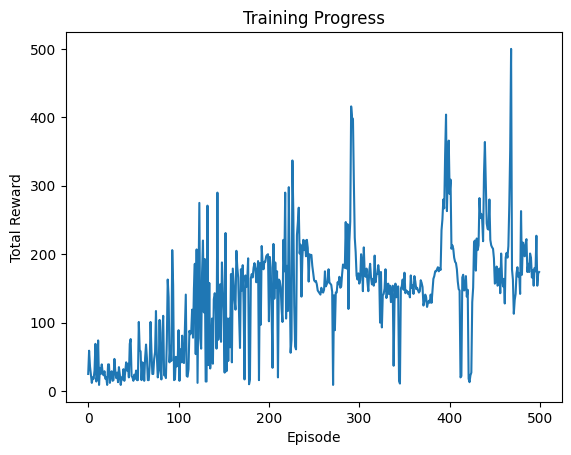

Total Reward: 336.0


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [17]:
### Step 8: Visualize the Results

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

### Step 9: Play the Game with the Trained Model

def play():
    state = env.reset()
    state = state[0] if isinstance(state, tuple) else state
    done = False
    total_reward = 0

    while not done:
        env.render()
        with torch.no_grad():
            action = torch.argmax(policy_net(preprocess_state(state))).item()
        state, reward, done, _, _ = env.step(action)
        total_reward += reward

    env.close()
    print(f'Total Reward: {total_reward}')

play()
